<a href="https://colab.research.google.com/github/poring3995/ML-Project-/blob/ML-Project/Project_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1 : Install pyspark to run algoirthm


In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=47a2779febaf3a66d23e112c02c1ead3b5c8d8090945e5bad7a8ebb807307eac
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


# Step 2: Create spark session

In [ ]:
from pyspark import SparkContext
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.linalg import DenseMatrix, Vectors


spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Classification project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#step 3 :Load the dataset from the google colab space
# in this case we used the "Stellar Classification Dataset - SDSS17"
# for this Project, URL: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

# The data consists of 100,000 observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 17 feature columns

# our target class :
# "class" column which identifies it to be either a star, galaxy or quasar (in the URL dataset they will not show the class column but in the real dataset it had this column )


# Since the dataset has alreaady have ther schema correctly and applicable with our algorithm, so we will set the inference schema to true for using the default schema from the datasource
# The header is already set it as well and we need to used this header as well for further processing, so for this option for the dataframe we will also set the header to true

In [ ]:
df = spark.read.csv('/content/star_classification.csv', header='true', inferSchema='true')

# step 4 : checking schema (also use this schema with the other process explanation )

In [ ]:
df.printSchema()

root
 |-- obj_ID: double (nullable = true)
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- run_ID: integer (nullable = true)
 |-- rerun_ID: integer (nullable = true)
 |-- cam_col: integer (nullable = true)
 |-- field_ID: integer (nullable = true)
 |-- spec_obj_ID: double (nullable = true)
 |-- class: string (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- fiber_ID: integer (nullable = true)



# step 5 : filter out some data columns that is not useful for our training

# drop :

#**all of the ID column and date(MJD column)** since it was not the numerical value that we can use for training (cam_cal, and plate is also the ID column but not just named as ID like the ther columns)

#**Class Column** because we will use it to be label column not features

In [ ]:
df = df.drop('rerun_ID', 'spec_obj_ID','obj_ID', 'run_ID', 'field_ID','fiber_ID', 'cam_col', 'plate','MjD' )

In [ ]:
df_noclass = df.drop('class')

df_noclass.printSchema()

root
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- redshift: double (nullable = true)



# step 6: Checking the missing value (either NAN or NULL)


In [ ]:
from pyspark.sql.functions import isnan, when, count, col, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
missing = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-----+-----+---+---+---+---+---+-----+--------+
|alpha|delta|  u|  g|  r|  i|  z|class|redshift|
+-----+-----+---+---+---+---+---+-----+--------+
|    0|    0|  0|  0|  0|  0|  0|    0|       0|
+-----+-----+---+---+---+---+---+-----+--------+

+-----+-----+---+---+---+---+---+-----+--------+
|alpha|delta|  u|  g|  r|  i|  z|class|redshift|
+-----+-----+---+---+---+---+---+-----+--------+
|    0|    0|  0|  0|  0|  0|  0|    0|       0|
+-----+-----+---+---+---+---+---+-----+--------+



# step 7 : transform all left colum into the features

In [ ]:
features = df_noclass.schema.names

vectorassembler = VectorAssembler(inputCols = features, outputCol= 'assemblerfeatures')

output_dataset = vectorassembler.transform(df_noclass)

output_dataset.show()

+----------------+------------------+--------+--------+--------+--------+--------+------------+--------------------+
|           alpha|             delta|       u|       g|       r|       i|       z|    redshift|   assemblerfeatures|
+----------------+------------------+--------+--------+--------+--------+--------+------------+--------------------+
|  135.6891066036|  32.4946318397087|23.87882| 22.2753|20.39501|19.16573|18.79371|   0.6347936|[135.6891066036,3...|
|144.826100550256|  31.2741848944939|24.77759|22.83188|22.58444|21.16812|21.61427|    0.779136|[144.826100550256...|
|142.188789562506|  35.5824441819976|25.26307|22.66389|20.60976|19.34857|18.94827|   0.6441945|[142.188789562506...|
|338.741037753146|-0.402827574587482|22.13682|23.77656|21.61162|20.50454| 19.2501|   0.9323456|[338.741037753146...|
|345.282593210935|  21.1838656010284|19.43718|17.58028|16.49747|15.97711|15.54461|   0.1161227|[345.282593210935...|
|340.995120509191|  20.5894762801019|23.48827|23.33776|21.32195|

# step 8 : convert the class column to index and vector

# since the data kin class column are in type of string , so in order to use it with pipeline we have to transform these data into the vector form  (which need to convert to convert to index first)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexer = StringIndexer(inputCols = ['class'], outputCols = ['classInd']).setHandleInvalid("skip")
onehot = OneHotEncoder(inputCols = ['classInd'], outputCols = ['classVec'])
stages = [indexer, onehot]
pipeline = Pipeline(stages=stages)
df_fea = pipeline.fit(df).transform(df)

In [ ]:
df_fea.show(1)

+--------------+----------------+--------+-------+--------+--------+--------+------+---------+--------+-------------+
|         alpha|           delta|       u|      g|       r|       i|       z| class| redshift|classInd|     classVec|
+--------------+----------------+--------+-------+--------+--------+--------+------+---------+--------+-------------+
|135.6891066036|32.4946318397087|23.87882|22.2753|20.39501|19.16573|18.79371|GALAXY|0.6347936|     0.0|(2,[0],[1.0])|
+--------------+----------------+--------+-------+--------+--------+--------+------+---------+--------+-------------+
only showing top 1 row



In [ ]:
df=df_fea

# step 9 : divided the data into the training and testing data

In [ ]:
(trainingData, testData) = df.randomSplit([0.7, 0.3],seed=123)

In [ ]:
trainingData.count(), testData.count()

(39352, 16970)

# step 10 : scaling the features data

# since the data is in very large amount, we need to used scaling to normalize the range of independent variables or features of data, makes the training more faster, effective and accurate

In [ ]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

features_columns = ['alpha','delta','u','g','r','i','z','redshift']
assembler = VectorAssembler(inputCols=features_columns, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures", min=0.0, max=1.0)
pipeline_preprocessing = Pipeline(stages=[assembler,scaler])
model_preprocessing = pipeline_preprocessing.fit(trainingData)
trainingData_scal = model_preprocessing.transform(trainingData)
testData_scal = model_preprocessing.transform(testData)

In [ ]:
trainingData_scal.show(5)

+-------------------+----------------+--------+--------+--------+--------+--------+------+---------+--------+-------------+--------------------+--------------------+
|              alpha|           delta|       u|       g|       r|       i|       z| class| redshift|classInd|     classVec|            features|      scaledFeatures|
+-------------------+----------------+--------+--------+--------+--------+--------+------+---------+--------+-------------+--------------------+--------------------+
|0.00552782792397011|21.7118518788006|21.90328|21.19124|  19.951|19.21397| 18.7945|GALAXY|0.5058863|     0.0|(2,[0],[1.0])|[0.00552782792397...|[0.0,0.3861782060...|
| 0.0133366618319997|1.50496725632891|20.67661|20.51553|20.51491|20.34745|20.33714|   QSO| 1.695679|     2.0|    (2,[],[])|[0.01333666183199...|[2.16915615590496...|
| 0.0242578849684492|  22.28844884659| 21.5686|21.56959|21.04366|21.11622|20.98896|   QSO| 1.145465|     2.0|    (2,[],[])|[0.02425788496844...|[5.20287907477528...|
| 0.

# Step 11 : Algorithm selection

# I choose the RandomTree Algoithms, since as I researched this algorithm can handle large datasets efficiently (scalability) which is very suitable for my dataset that quite in the large size, also provide a higher accuracy when compared to other algorithms such as decision tree algorithms



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# step 12 : training with varies amount of tree to find the best number of tree in random forest first

In [ ]:
accuracy = list()
for i in range(10,110,10):
  rf = RandomForestClassifier(labelCol="classInd", featuresCol="scaledFeatures", numTrees=i)
  model_rf = rf.fit(trainingData_scal)
  predictions = model_rf.transform(testData_scal)
  acc=MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='classInd', metricName='accuracy')
  accuracy.append(acc.evaluate(predictions))

[]

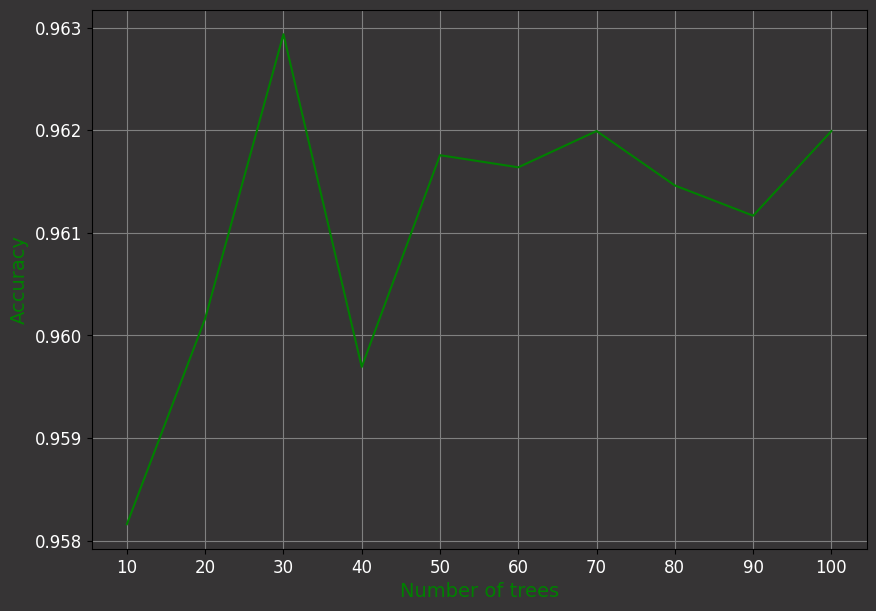

In [ ]:
labels=['10','20','30','40','50','60','70','80','90','100']


plt.rcParams['axes.facecolor'] = '#363435'
plt.figure(facecolor='#363435', figsize=(10,7))
plt.plot(labels,accuracy, color='green')
plt.xlabel('Number of trees', color='green', size= 14)
plt.ylabel('Accuracy', color='green', size=14)
plt.xticks(color='white', size=12)
plt.yticks(color='white', size=12)
plt.grid(color='#808080')


plt.plot()

# step 13 : check the final result after applies to the best number of tree (which is 30)

In [ ]:
rf = RandomForestClassifier(labelCol="classInd", featuresCol="scaledFeatures", numTrees=30)
model_rf = rf.fit(trainingData_scal)
predictions = model_rf.transform(testData_scal)

accuracy_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='classInd', metricName='accuracy')
print("RandomForest with 90 number of tree", "accuracy : ", accuracy_f1.evaluate(predictions))

RandomForest with 90 number of tree accuracy :  0.9629345904537419


# Data visualization : use the confusion matrix to show the possibility of the result that could goes wrong when compared to the true value

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


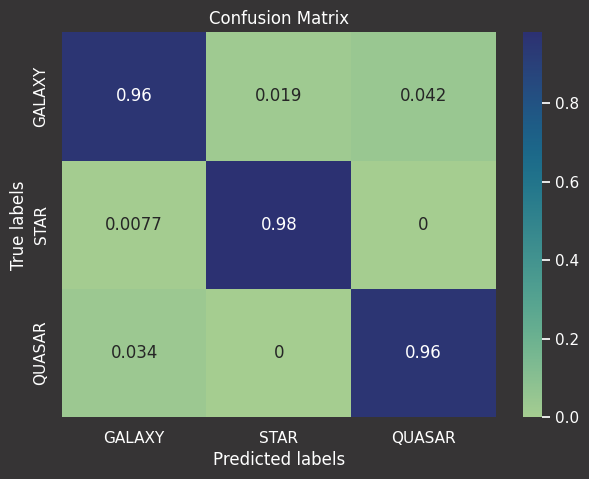

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np

predictionAndLabels = predictions.select("prediction", "classInd").rdd.map(lambda row: (row.prediction, float(row.classInd)))
metrics = MulticlassMetrics(predictionAndLabels)
cfmx = metrics.confusionMatrix()
cfarr = cfmx.toArray()
confusionmatrix = pd.DataFrame(cfarr)

ax= plt.subplot()
sns.set(rc={'figure.figsize':(7,5), 'axes.facecolor':'#363435', 'figure.facecolor':'#363435','axes.labelcolor': 'white',
            'xtick.color': 'white', 'ytick.color': 'white'})
sns.heatmap(confusionmatrix/np.sum(confusionmatrix), annot=True,cmap='crest')
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels");
ax.set_title("Confusion Matrix",color='white');
ax.xaxis.set_ticklabels(["GALAXY", "STAR", "QUASAR"])
ax.yaxis.set_ticklabels(["GALAXY", "STAR", "QUASAR"])
plt.show()